In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("bace.csv")

In [3]:
df.head(1)

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.0,7.98017,0.0,0.0,1


In [4]:
mols = [Chem.MolFromSmiles(smi) for smi in df.mol]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=1024) for mol in mols]
pIC50 = [i for i in df.pIC50]

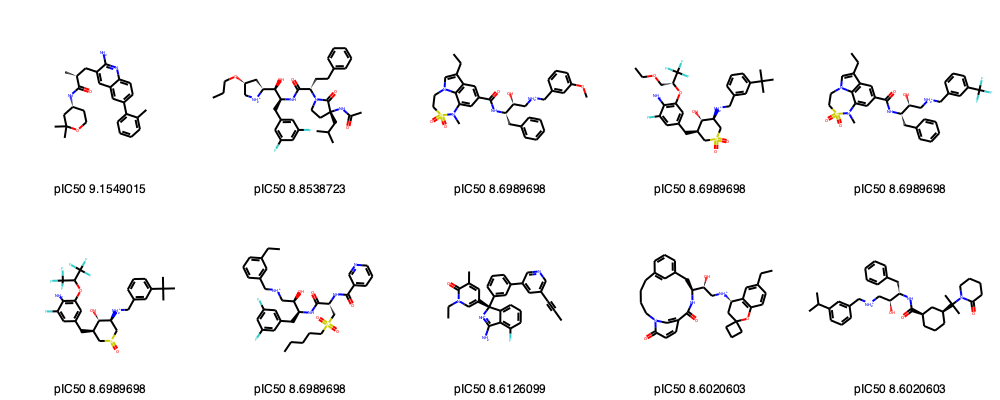

In [5]:
Draw.MolsToGridImage(mols[:10], legends=["pIC50 "+str(i) for i in pIC50[:10]], molsPerRow=5)

In [6]:
X = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    X.append(arr)
X = np.array(X)
y = np.array(pIC50)
y_bin = np.asarray(y>7, dtype=np.int)

In [7]:
import matplotlib.pyplot as plt

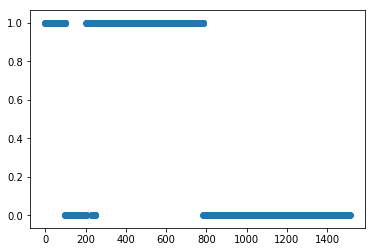

In [8]:
plt.scatter(range(len(y_bin)), y_bin)

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X,y_bin, test_size=0.2)

In [11]:
clf1 = RandomForestClassifier(random_state=794)
clf2 = GaussianNB()
clf3 = XGBClassifier(random_state=0)
clf4 = SVC(random_state=0)
clflist = ["RF", "GNB", "XGB", "SVC", "SCLF"]


In [12]:
sclf = StackingClassifier(classifiers=[clf1,clf2,clf3], meta_classifier=clf4)

In [13]:
skf = StratifiedKFold(n_splits=5)

In [14]:
for j, (train_idx,test_idx) in enumerate(skf.split(x_train, y_train)):
    for i, clf in enumerate([clf1, clf2, clf3, clf4, sclf]):
        clf.fit(x_train[train_idx],y_train[train_idx])
        ypred = clf.predict(x_train[test_idx])
        acc = accuracy_score(y_train[test_idx], ypred)
        b_acc = balanced_accuracy_score(y_train[test_idx], ypred)
        print("round {}".format(j))
        print(clflist[i])
        print("accuracy {}".format(acc))
        print("balanced accuracy {}".format(b_acc))
        print("="*20)

round 0
RF
accuracy 0.8148148148148148
balanced accuracy 0.8026786943947115
round 0
GNB
accuracy 0.6625514403292181
balanced accuracy 0.680450351191296
round 0
XGB
accuracy 0.8271604938271605
balanced accuracy 0.8136275995042005
round 0
SVC
accuracy 0.7325102880658436
balanced accuracy 0.7072717256576229
round 0
SCLF
accuracy 0.8148148148148148
balanced accuracy 0.8026786943947115
round 1
RF
accuracy 0.7603305785123967
balanced accuracy 0.7534683684794672
round 1
GNB
accuracy 0.640495867768595
balanced accuracy 0.6634988901220866
round 1
XGB
accuracy 0.8140495867768595
balanced accuracy 0.8127081021087681
round 1
SVC
accuracy 0.756198347107438
balanced accuracy 0.7414678135405106
round 1
SCLF
accuracy 0.7603305785123967
balanced accuracy 0.7534683684794672
round 2
RF
accuracy 0.7768595041322314
balanced accuracy 0.7640122086570478
round 2
GNB
accuracy 0.6942148760330579
balanced accuracy 0.714414539400666
round 2
XGB
accuracy 0.8347107438016529
balanced accuracy 0.8300499445061044
roun

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1f0e75f8>)

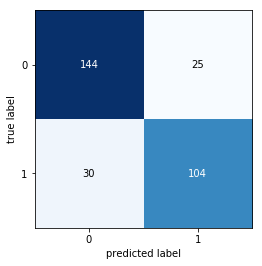

In [15]:
ypred = sclf.predict(x_test)
plot_confusion_matrix(confusion_matrix(y_test, ypred))